In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [ ]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

def power(base: int, exponent: int) -> int:
    """Raise base to the power of exponent.

    Args:
        base: base integer
        exponent: exponent integer
    """
    return base ** exponent

def modulo(dividend: int, divisor: int) -> int:
    """Calculate the remainder when dividend is divided by divisor.

    Args:
        dividend: number to be divided
        divisor: number to divide by
    """
    return dividend % divisor

def subtract(a: int, b: int) -> int:
    """Subtract b from a.

    Args:
        a: first int
        b: second int
    """
    return a - b

tools = [add, multiply, divide, power, modulo, subtract]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

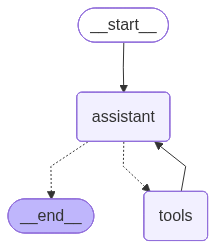

In [3]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=MemorySaver())

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [4]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_rc2t4RpPNiic7AVHZxMGKYGm)
 Call ID: call_rc2t4RpPNiic7AVHZxMGKYGm
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


In [5]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='9f6a6fad-9902-400d-b6bb-e4e3f51e68a1'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_rc2t4RpPNiic7AVHZxMGKYGm', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 131, 'total_tokens': 148, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_ed643dde95', 'id': 'chatcmpl-ChoEhaXPDj4XDNlvhl4U6NTr9i23w', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--5c267ae5-fdae-4f63-ab4d-062cecc5a991-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_rc2t4Rp

In [6]:
all_states = [s for s in graph.get_state_history(thread)]

In [7]:
len(all_states)

5

In [8]:
all_states[-2]

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='9f6a6fad-9902-400d-b6bb-e4e3f51e68a1')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0ce601-17ae-626c-8000-20e92fc60d14'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-10-25T15:24:25.393367+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0ce601-17a8-6802-bfff-974aed18a6f6'}}, tasks=(PregelTask(id='9bbb6758-92b2-902a-54e4-7d623ab973cd', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_rc2t4RpPNiic7AVHZxMGKYGm', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 131, 

In [9]:
to_replay = all_states[-2]

In [10]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='9f6a6fad-9902-400d-b6bb-e4e3f51e68a1')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0ce601-17ae-626c-8000-20e92fc60d14'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-10-25T15:30:25.393367+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0ce601-17a8-6802-bfff-974aed18a6f6'}}, tasks=(PregelTask(id='9bbb6758-92b2-902a-54e4-7d623ab973cd', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_rc2t4RpPNiic7AVHZxMGKYGm', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 131, 

In [11]:
to_replay.values

{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='9f6a6fad-9902-400d-b6bb-e4e3f51e68a1')]}

In [12]:
to_replay.next

('assistant',)

In [13]:
to_replay.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0ce601-17ae-626c-8000-20e92fc60d14'}}

In [14]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_UIcDQmzDefmFDFqqK6scz45Y)
 Call ID: call_UIcDQmzDefmFDFqqK6scz45Y
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


In [15]:
to_fork = all_states[-2]
to_fork.values["messages"]

[HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='9f6a6fad-9902-400d-b6bb-e4e3f51e68a1')]

In [16]:
to_fork.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0ce601-17ae-626c-8000-20e92fc60d14'}}

In [17]:
fork_config = graph.update_state(
    to_fork.config,
    {"messages": [HumanMessage(content='Multiply 5 and 3', 
                               id=to_fork.values["messages"][0].id)]},
)

In [18]:
fork_config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0ce608-1d24-6c31-8001-41b577bc7a02'}}

In [19]:
all_states = [state for state in graph.get_state_history(thread) ]
all_states[0].values["messages"]

[HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='9f6a6fad-9902-400d-b6bb-e4e3f51e68a1'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_rc2t4RpPNiic7AVHZxMGKYGm', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 131, 'total_tokens': 148, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_ed643dde95', 'id': 'chatcmpl-ChoEhaXPDj4XDNlvhl4U6NTr9i23w', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--5c267ae5-fdae-4f63-ab4d-062cecc5a991-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_rc2t4RpPNiic7AVHZxMGKYGm', 'type': 'tool

In [20]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='9f6a6fad-9902-400d-b6bb-e4e3f51e68a1'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_rc2t4RpPNiic7AVHZxMGKYGm', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 131, 'total_tokens': 148, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_ed643dde95', 'id': 'chatcmpl-ChoEhaXPDj4XDNlvhl4U6NTr9i23w', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--5c267ae5-fdae-4f63-ab4d-062cecc5a991-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_rc2t4Rp

In [21]:
for event in graph.stream(None, fork_config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (call_rc2t4RpPNiic7AVHZxMGKYGm)
 Call ID: call_rc2t4RpPNiic7AVHZxMGKYGm
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 5 and 3 is 15.


In [22]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='9f6a6fad-9902-400d-b6bb-e4e3f51e68a1'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_rc2t4RpPNiic7AVHZxMGKYGm', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 131, 'total_tokens': 148, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_ed643dde95', 'id': 'chatcmpl-ChoEhaXPDj4XDNlvhl4U6NTr9i23w', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--5c267ae5-fdae-4f63-ab4d-062cecc5a991-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_rc2t4Rp

In [23]:
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

In [24]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id = "agent",
    input=initial_input,
    stream_mode="updates",
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])



--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_hV21yTE6hp8k2DW1jjJ5kmfQ', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_ed643dde95', 'id': 'chatcmpl-ChoLZOqs1hR4ujmHzL1zlsT8VfCqT', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run--0b223c77-f540-4bc5-abec-4737aee2a0c8-0', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_hV21yTE6hp8k2DW1jjJ5kmfQ', 'type': 'tool_call'}], 'invalid_tool_

In [25]:
states = await client.threads.get_history(thread['thread_id'])
to_replay = states[-2]
to_replay

{'values': {'messages': [{'content': 'Multiply 2 and 3',
    'additional_kwargs': {},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': '3d1c61a8-4582-49a3-903e-dcc98a5d98d2',
    'example': False}]},
 'next': ['assistant'],
 'tasks': [{'id': '328c0013-e091-c519-14bf-393c9d07ef17',
   'name': 'assistant',
   'path': ['__pregel_pull', 'assistant'],
   'error': None,
   'interrupts': [],
   'checkpoint': None,
   'state': None,
   'result': {'messages': [{'content': '',
      'additional_kwargs': {'tool_calls': [{'id': 'call_hV21yTE6hp8k2DW1jjJ5kmfQ',
         'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'},
         'type': 'function'}],
       'refusal': None},
      'response_metadata': {'token_usage': {'completion_tokens': 17,
        'prompt_tokens': 134,
        'total_tokens': 151,
        'completion_tokens_details': {'accepted_prediction_tokens': 0,
         'audio_tokens': 0,
         'reasoning_tokens': 0,
         'rejected_predictio

In [26]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    checkpoint_id=to_replay['checkpoint_id']
):      
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '019ad7d6-48cd-709a-b5bf-14be80d94830', 'attempt': 1}



Receiving new event of type: values...
{'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '3d1c61a8-4582-49a3-903e-dcc98a5d98d2', 'example': False}]}



Receiving new event of type: values...
{'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '3d1c61a8-4582-49a3-903e-dcc98a5d98d2', 'example': False}, {'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_CTe8WbmSimvqb88XBwlvMYAV', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_predict

In [27]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="updates",
    checkpoint_id=to_replay['checkpoint_id']
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])



--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_aNPrLnnmNT8Ion1tDxHeVz8X', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_ed643dde95', 'id': 'chatcmpl-ChoN0H97twVUcWo1Snqd5q6Ix9mLn', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run--49580dee-4e2d-4fd4-b1d0-4a3c20ed8fe9-0', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_aNPrLnnmNT8Ion1tDxHeVz8X', 'type': 'tool_call'}], 'invalid_tool_

In [28]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=initial_input,
    stream_mode="updates",
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_PAoGdNfZgdahgq78286xGGoR', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_ed643dde95', 'id': 'chatcmpl-ChoNNlEDaFCt5cbfjoG8qLojwckWP', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run--868869f4-8eca-488d-8922-3dda54f9db3a-0', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_PAoGdNfZgdahgq78286xGGoR', 'type': 'tool_call'}], 'invalid_tool_

In [29]:
states = await client.threads.get_history(thread['thread_id'])
to_fork = states[-2]
to_fork['values']

{'messages': [{'content': 'Multiply 2 and 3',
   'additional_kwargs': {},
   'response_metadata': {},
   'type': 'human',
   'name': None,
   'id': 'f698831a-e468-4762-9e5a-2f0c8db51676',
   'example': False}]}

In [30]:
to_fork['values']['messages'][0]['id']

'f698831a-e468-4762-9e5a-2f0c8db51676'

In [31]:
to_fork['next']

['assistant']

In [32]:
to_fork['checkpoint_id']

'1f0ce615-2948-66c7-8000-801f5a7a6b8a'

In [33]:
forked_input = {"messages": HumanMessage(content="Multiply 3 and 3",
                                         id=to_fork['values']['messages'][0]['id'])}

forked_config = await client.threads.update_state(
    thread["thread_id"],
    forked_input,
    checkpoint_id=to_fork['checkpoint_id']
)

In [34]:
forked_config

{'checkpoint': {'thread_id': '5cf9d65f-d7fb-45ce-b7d8-aee7bb0e8320',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0ce617-0674-6ee3-8001-d973c2ac41e8'},
 'configurable': {'thread_id': '5cf9d65f-d7fb-45ce-b7d8-aee7bb0e8320',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0ce617-0674-6ee3-8001-d973c2ac41e8'},
 'checkpoint_id': '1f0ce617-0674-6ee3-8001-d973c2ac41e8'}

In [35]:
states = await client.threads.get_history(thread['thread_id'])
states[0]

{'values': {'messages': [{'content': 'Multiply 3 and 3',
    'additional_kwargs': {},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': 'f698831a-e468-4762-9e5a-2f0c8db51676',
    'example': False},
   {'content': '',
    'additional_kwargs': {'tool_calls': [{'id': 'call_PAoGdNfZgdahgq78286xGGoR',
       'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'},
       'type': 'function'}],
     'refusal': None},
    'response_metadata': {'token_usage': {'completion_tokens': 17,
      'prompt_tokens': 134,
      'total_tokens': 151,
      'completion_tokens_details': {'accepted_prediction_tokens': 0,
       'audio_tokens': 0,
       'reasoning_tokens': 0,
       'rejected_prediction_tokens': 0},
      'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
     'model_name': 'gpt-4o-2024-08-06',
     'system_fingerprint': 'fp_ed643dde95',
     'id': 'chatcmpl-ChoNNlEDaFCt5cbfjoG8qLojwckWP',
     'service_tier': 'default',
     'finish_reason'

In [36]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="updates",
    checkpoint_id=forked_config['checkpoint_id']
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Tools Node--------------------
{'content': '6', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'multiply', 'id': '5ed96df2-27d3-4d25-af00-6e614d562c36', 'tool_call_id': 'call_PAoGdNfZgdahgq78286xGGoR', 'artifact': None, 'status': 'success'}
--------------------Assistant Node--------------------
{'content': '3 multiplied by 3 equals 9.', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 10, 'prompt_tokens': 159, 'total_tokens': 169, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_ed643dde95', 'id': 'chatcmpl-ChoOnKlyOZzeSaapcaUP34xJMP35m', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run--e5b1d9fb-b7af-4c8a-9b6b-a1121